This example covers the callable methods of the Python AWIPS DAF when working with gridded data.  We start with a connection to an EDEX server, then query data types, then grid names, parameters, levels, and other information. Finally the gridded data is plotted for its domain using Matplotlib and Cartopy.

## DataAccessLayer.getSupportedDatatypes()

getSupportedDatatypes() returns a list of available data types offered by the EDEX server defined above. 

In [1]:
from awips.dataaccess import DataAccessLayer
import unittest

DataAccessLayer.changeEDEXHost("edex-cloud.unidata.ucar.edu")
dataTypes = DataAccessLayer.getSupportedDatatypes()
dataTypes.sort()
list(dataTypes)

['acars',
 'airep',
 'binlightning',
 'bufrmosAVN',
 'bufrmosETA',
 'bufrmosGFS',
 'bufrmosHPC',
 'bufrmosLAMP',
 'bufrmosMRF',
 'bufrua',
 'climate',
 'common_obs_spatial',
 'gfe',
 'gfeEditArea',
 'grid',
 'maps',
 'modelsounding',
 'obs',
 'pirep',
 'practicewarning',
 'profiler',
 'radar',
 'radar_spatial',
 'satellite',
 'sfcobs',
 'topo',
 'warning']

## DataAccessLayer.getAvailableLocationNames()

Now create a new data request, and set the data type to **grid** to request all available grids with **getAvailableLocationNames()**

In [2]:
request = DataAccessLayer.newDataRequest()
request.setDatatype("grid")
available_grids = DataAccessLayer.getAvailableLocationNames(request)
available_grids.sort()
list(available_grids)

['AUTOSPE',
 'CMC',
 'ESTOFS',
 'ETSS',
 'FFG-ALR',
 'FFG-FWR',
 'FFG-KRF',
 'FFG-MSR',
 'FFG-ORN',
 'FFG-PTR',
 'FFG-RHA',
 'FFG-RSA',
 'FFG-STR',
 'FFG-TAR',
 'FFG-TIR',
 'FFG-TUA',
 'GEFS',
 'GFS',
 'GFS20',
 'HFR-EAST_6KM',
 'HFR-EAST_PR_6KM',
 'HFR-US_EAST_DELAWARE_1KM',
 'HFR-US_EAST_FLORIDA_2KM',
 'HFR-US_EAST_NORTH_2KM',
 'HFR-US_EAST_SOUTH_2KM',
 'HFR-US_EAST_VIRGINIA_1KM',
 'HFR-US_HAWAII_1KM',
 'HFR-US_HAWAII_2KM',
 'HFR-US_HAWAII_6KM',
 'HFR-US_WEST_500M',
 'HFR-US_WEST_CENCAL_2KM',
 'HFR-US_WEST_LOSANGELES_1KM',
 'HFR-US_WEST_LOSOSOS_1KM',
 'HFR-US_WEST_NORTH_2KM',
 'HFR-US_WEST_SANFRAN_1KM',
 'HFR-US_WEST_SOCAL_2KM',
 'HFR-US_WEST_WASHINGTON_1KM',
 'HFR-WEST_6KM',
 'HPCGuide',
 'HPCqpfNDFD',
 'HRRR',
 'LAMP2p5',
 'MRMS_0500',
 'MRMS_1000',
 'NAM12',
 'NAM40',
 'NOHRSC-SNOW',
 'NationalBlend',
 'RAP13',
 'RTMA',
 'RTOFS-Now-WestAtl',
 'RTOFS-Now-WestConus',
 'RTOFS-WestAtl',
 'RTOFS-WestConus',
 'SPCGuide',
 'SeaIce',
 'TPCWindProb',
 'URMA25',
 'WaveWatch']

## DataAccessLayer.getAvailableParameters()

After datatype and model name (locationName) are set, you can query all available parameters with **getAvailableParameters()**

In [3]:
request.setLocationNames("RAP13")
availableParms = DataAccessLayer.getAvailableParameters(request)
availableParms.sort()
list(availableParms)

['36SHRMi',
 '50dbzZ',
 'AV',
 'Along',
 'AppT',
 'BLI',
 'BRN',
 'BRNEHIi',
 'BRNSHR',
 'BRNmag',
 'BRNvec',
 'BdEPT06',
 'BlkMag',
 'BlkShr',
 'CAPE',
 'CFRZR',
 'CICEP',
 'CIn',
 'CP',
 'CP1hr',
 'CPr',
 'CPrD',
 'CRAIN',
 'CSNOW',
 'CURU',
 'CXR',
 'CapeStk',
 'Corf',
 'CorfF',
 'CorfFM',
 'CorfM',
 'CritT1',
 'CumNrm',
 'CumShr',
 'DivF',
 'DivFn',
 'DivFs',
 'DpD',
 'DpT',
 'EHI',
 'EHI01',
 'EHIi',
 'EPT',
 'EPTA',
 'EPTC',
 'EPTGrd',
 'EPTGrdM',
 'EPTs',
 'EPVg',
 'EPVs',
 'EPVt1',
 'EPVt2',
 'ESP',
 'ESP2',
 'FVecs',
 'FeatMot',
 'FnVecs',
 'FsVecs',
 'Fzra1',
 'Fzra2',
 'GH',
 'GHxSM',
 'GHxSM2',
 'Gust',
 'HI',
 'HI1',
 'HI3',
 'HI4',
 'HIdx',
 'HPBL',
 'Heli',
 'HeliC',
 'INV',
 'IPLayer',
 'Into',
 'KI',
 'L-I',
 'LIsfc2x',
 'LM5',
 'LM6',
 'MAdv',
 'MCon',
 'MCon2',
 'MLLCL',
 'MMP',
 'MMSP',
 'MSFDi',
 'MSFi',
 'MSFmi',
 'MSG',
 'MTV',
 'Mix1',
 'Mix2',
 'Mmag',
 'MpV',
 'NBE',
 'NST',
 'NST1',
 'NST2',
 'OmDiff',
 'P',
 'PAdv',
 'PBE',
 'PEC',
 'PFrnt',
 'PGrd',
 'PGrd1

## DataAccessLayer.getAvailableLevels()

Selecting **"T"** for temperature.

In [4]:
request.setParameters("T")
availableLevels = DataAccessLayer.getAvailableLevels(request)
for lvl in availableLevels:
    print(lvl)

0.0SFC
350.0MB
475.0MB
610.0_40000.0FHAG
225.0MB
120.0_150.0BL
900.0MB
125.0MB
0.0_610.0FHAG
450.0MB
575.0MB
325.0MB
100.0MB
1000.0MB
60.0_90.0BL
275.0MB
1.0PV
950.0MB
150.0MB
1.5PV
700.0MB
825.0MB
150.0_180.0BL
250.0MB
375.0MB
1000.0_500.0MB
800.0MB
4000.0FHAG
925.0MB
2.0PV
0.5PV
0.0TROP
750.0MB
500.0MB
625.0MB
400.0MB
0.0FHAG
2.0FHAG
875.0MB
175.0MB
0.0_1000.0FHAG
850.0MB
600.0MB
725.0MB
0.0_6000.0FHAG
975.0MB
550.0MB
0.0_3000.0FHAG
675.0MB
425.0MB
200.0MB
0.0_30.0BL
30.0_60.0BL
650.0MB
525.0MB
300.0MB
90.0_120.0BL
1000.0FHAG
775.0MB
340.0_350.0K
290.0_300.0K
700.0_600.0MB
700.0_300.0MB
320.0Ke
800.0_750.0MB
60.0TILT
5.3TILT
1000.0_900.0MB
340.0K
5500.0_6000.0FHAG
255.0K
255.0_265.0K
3000.0_6000.0FHAG
25.0TILT
2000.0FHAG
0.0_500.0FHAG
1000.0_850.0MB
850.0_250.0MB
280.0_290.0Ke
1524.0FHAG
320.0_330.0K
0.0TILT
310.0_320.0Ke
310.0Ke
330.0K
900.0_800.0MB
550.0_500.0MB
2.4TILT
50.0TILT
3500.0FHAG
35.0TILT
12.0TILT
300.0_310.0K
3000.0_12000.0FHAG
0.9TILT
320.0K
400.0_350.0MB
500.0FHAG
750.

* **0.0SFC** is the Surface level
* **FHAG** stands for Fixed Height Above Ground (in meters)
* **NTAT** stands for Nominal Top of the ATmosphere
* **BL** stands for Boundary Layer, where **0.0_30.0BL** reads as *0-30 mb above ground level*  
* **TROP** is the Tropopause level

**request.setLevels()**

For this example we will use Surface Temperature

In [5]:
request.setLevels("2.0FHAG")

## DataAccessLayer.getAvailableTimes()

* **getAvailableTimes(request, True)** will return an object of *run times* - formatted as `YYYY-MM-DD HH:MM:SS`
* **getAvailableTimes(request)** will return an object of all times - formatted as `YYYY-MM-DD HH:MM:SS (F:ff)`
* **getForecastRun(cycle, times)** will return a DataTime array for a single forecast cycle.

In [6]:
cycles = DataAccessLayer.getAvailableTimes(request, True)
times = DataAccessLayer.getAvailableTimes(request)
fcstRun = DataAccessLayer.getForecastRun(cycles[-1], times)
list(fcstRun)

[<DataTime instance: 2020-09-04 16:00:00 >,
 <DataTime instance: 2020-09-04 16:00:00 >,
 <DataTime instance: 2020-09-04 16:00:00 >,
 <DataTime instance: 2020-09-04 16:00:00 >,
 <DataTime instance: 2020-09-04 16:00:00 >,
 <DataTime instance: 2020-09-04 16:00:00 >,
 <DataTime instance: 2020-09-04 16:00:00 >,
 <DataTime instance: 2020-09-04 16:00:00 >,
 <DataTime instance: 2020-09-04 16:00:00 >,
 <DataTime instance: 2020-09-04 16:00:00 >,
 <DataTime instance: 2020-09-04 16:00:00 >,
 <DataTime instance: 2020-09-04 16:00:00 >,
 <DataTime instance: 2020-09-04 16:00:00 >,
 <DataTime instance: 2020-09-04 16:00:00 >,
 <DataTime instance: 2020-09-04 16:00:00 >,
 <DataTime instance: 2020-09-04 16:00:00 >,
 <DataTime instance: 2020-09-04 16:00:00 >]

## DataAccessLayer.getGridData()

Now that we have our `request` and DataTime `fcstRun` arrays ready, it's time to request the data array from EDEX.

In [7]:
response = DataAccessLayer.getGridData(request, [fcstRun[-1]])
for grid in response:
    data = grid.getRawData()
    lons, lats = grid.getLatLonCoords()
    print('Time :', str(grid.getDataTime()))

print('Model:', str(grid.getLocationName()))
print('Parm :', str(grid.getParameter()))
print('Unit :', str(grid.getUnit()))
print(data.shape)

Time : 2020-09-04 16:00:00
Model: RAP13
Parm : T
Unit : K
(337, 451)


## Plotting with Matplotlib and Cartopy

**1. pcolormesh**

Matplotlib is building the font cache; this may take a moment.


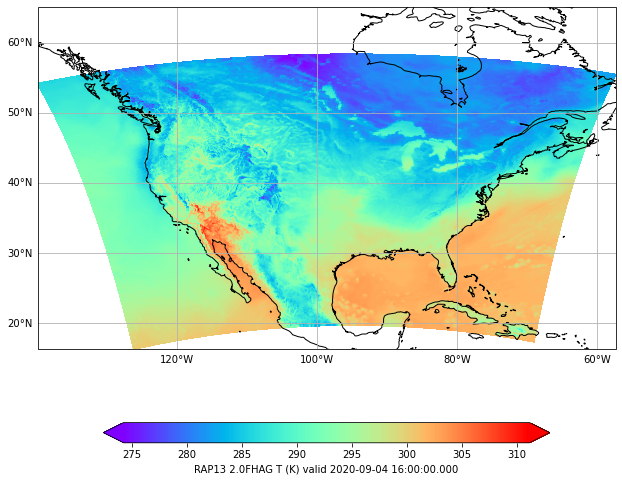

In [8]:
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import numpy as np
import numpy.ma as ma
from scipy.io import loadmat
def make_map(bbox, projection=ccrs.PlateCarree()):
    fig, ax = plt.subplots(figsize=(16, 9),
                           subplot_kw=dict(projection=projection))
    ax.set_extent(bbox)
    ax.coastlines(resolution='50m')
    gl = ax.gridlines(draw_labels=True)
    gl.top_labels = gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    return fig, ax

cmap = plt.get_cmap('rainbow')
bbox = [lons.min(), lons.max(), lats.min(), lats.max()]
fig, ax = make_map(bbox=bbox)
cs = ax.pcolormesh(lons, lats, data, cmap=cmap)
cbar = fig.colorbar(cs, extend='both', shrink=0.5, orientation='horizontal')
cbar.set_label(grid.getLocationName() +" " + grid.getLevel() + " " \
               + grid.getParameter() + " (" + grid.getUnit() + ") " \
               + "valid " + str(grid.getDataTime().getRefTime()))

**2. contourf**

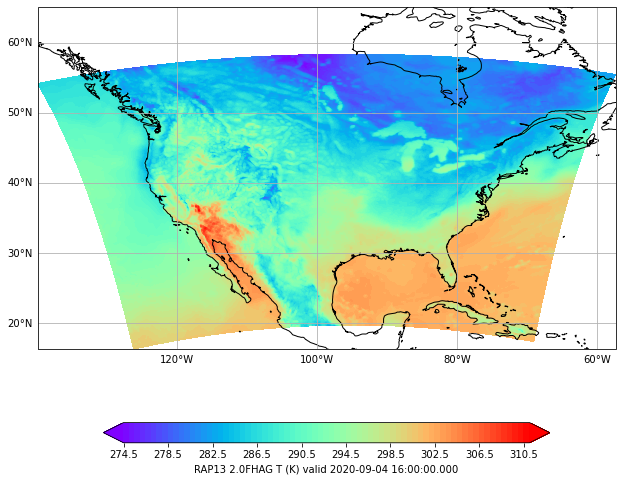

In [9]:
fig2, ax2 = make_map(bbox=bbox)
cs2 = ax2.contourf(lons, lats, data, 80, cmap=cmap,
                  vmin=data.min(), vmax=data.max(), extend='both')
cbar2 = fig2.colorbar(cs2, shrink=0.5, orientation='horizontal')
cbar2.set_label(grid.getLocationName() +" " + grid.getLevel() + " " \
               + grid.getParameter() + " (" + grid.getUnit() + ") " \
               + "valid " + str(grid.getDataTime().getRefTime()))